# Progetto Corò Elia

In [1]:
# Import libraries
# Standard Libraries
import os
import itertools
import numpy as np
import pandas as pd
from collections import Counter
import itertools

# Scientific Computing Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

# Scikit-learn Libraries
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.semi_supervised import LabelPropagation
from sklearn.utils.class_weight import compute_sample_weight

# LightGBM
import lightgbm as lgb

# TensorFlow/Keras Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

# Custom Utilities & Cleaning Functions
from utils.print_confusion_matrix import print_confusion_matrix
from utils.print_correlation_matrix import PrintCorrelationMatrix
from utils.plot_features_with_outliers import plot_features_with_outliers

from cleaning.rfe_selection import rfe_selection
from cleaning.rfecv_selection import rfecv_selection
from cleaning.fill_missing_values import fill_missing_values
from cleaning.remove_high_missing_fields import remove_high_missing_fields
from cleaning.remove_high_missing_columns import remove_high_missing_columns
from cleaning.one_hot_encoder import OneHotEncoderFunction

models = []
ids = []

2025-01-30 14:37:38.642424: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 14:37:38.648212: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 14:37:38.697782: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 14:37:38.745845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738244258.785366   88119 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738244258.79

# Descrizione del Dataset

Descrizione delle varie features contenute all'interno del dataset:

---

## **Identificatore**

- **id** -> (string) ID del partecipante

---

## **Demografia**

- **Basic_Demos-Enroll_Season** -> (string) Stagione di iscrizione (Primavera, Estate, Autunno, Inverno)  
- **Basic_Demos-Age** -> (float) Età del partecipante  
- **Basic_Demos-Sex** -> (int categoriale) Sesso del partecipante (0 = Maschio, 1 = Femmina)

---

## **Child Global Assessment Scale (CGAS)**

- **CGAS-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **CGAS-CGAS_Score** -> (int) Punteggio della Scala di Valutazione Globale del Bambino (CGAS)

---

## **Misure fisiche**

- **Physical-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **Physical-BMI** -> (float) Indice di Massa Corporea (kg/m^2)  
- **Physical-Height** -> (float) Altezza (in)  
- **Physical-Weight** -> (float) Peso (lbs)  
- **Physical-Waist_Circumference** -> (int) Circonferenza vita (in)  
- **Physical-Diastolic_BP** -> (int) Pressione sanguigna diastolica (mmHg)  
- **Physical-HeartRate** -> (int) Frequenza cardiaca (battiti/min)  
- **Physical-Systolic_BP** -> (int) Pressione sanguigna sistolica (mmHg)

---

## **FitnessGram Vitals and Treadmill**

- **Fitness_Endurance-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **Fitness_Endurance-Max_Stage** -> (int) Massimo stadio raggiunto  
- **Fitness_Endurance-Time_Mins** -> (int) Tempo esatto completato: Minuti  
- **Fitness_Endurance-Time_Sec** -> (int) Tempo esatto completato: Secondi

---

## **FitnessGram Child**

- **FGC-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **FGC-FGC_CU** -> (int) Numero totale di curl up  
- **FGC-FGC_CU_Zone** -> (int categoriale) Zona di fitness curl up (0 = Necessita miglioramenti, 1 = Zona di fitness sana)  
- **FGC-FGC_GSND** -> (float) Forza di presa totale (non dominante)  
- **FGC-FGC_GSND_Zone** -> (int categoriale) Zona di fitness forza di presa (non dominante) (1 = Debole, 2 = Normale, 3 = Forte)  
- **FGC-FGC_GSD** -> (float) Forza di presa totale (dominante)  
- **FGC-FGC_GSD_Zone** -> (int categoriale) Zona di fitness forza di presa (dominante) (1 = Debole, 2 = Normale, 3 = Forte)  
- **FGC-FGC_PU** -> (int) Numero totale di push-up  
- **FGC-FGC_PU_Zone** -> (int categoriale) Zona di fitness push-up (0 = Necessita miglioramenti, 1 = Zona di fitness sana)  
- **FGC-FGC_SRL** -> (float) Totale sit & reach (lato sinistro)  
- **FGC-FGC_SRL_Zone** -> (int categoriale) Zona di fitness sit & reach (lato sinistro) (0 = Necessita miglioramenti, 1 = Zona di fitness sana)  
- **FGC-FGC_SRR** -> (float) Totale sit & reach (lato destro)  
- **FGC-FGC_SRR_Zone** -> (int categoriale) Zona di fitness sit & reach (lato destro) (0 = Necessita miglioramenti, 1 = Zona di fitness sana)  
- **FGC-FGC_TL** -> (int) Totale trunk lift  
- **FGC-FGC_TL_Zone** -> (int categoriale) Zona di fitness trunk lift (0 = Necessita miglioramenti, 1 = Zona di fitness sana)

---

## **Bioelectrical Impedance Analysis**

- **BIA-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **BIA-BIA_Activity_Level_num** -> (int categoriale) Livello di attività (1 = Molto leggera, 2 = Leggera, 3 = Moderata, 4 = Pesante, 5 = Eccezionale)  
- **BIA-BIA_BMC** -> (float) Contenuto Minerale Osseo  
- **BIA-BIA_BMI** -> (float) Indice di Massa Corporea  
- **BIA-BIA_BMR** -> (float) Metabolismo Basale  
- **BIA-BIA_DEE** -> (float) Dispendio Energetico Giornaliero  
- **BIA-BIA_ECW** -> (float) Acqua Extracellulare  
- **BIA-BIA_FFM** -> (float) Massa Magra  
- **BIA-BIA_FFMI** -> (float) Indice Massa Magra  
- **BIA-BIA_FMI** -> (float) Indice di Massa Grassa  
- **BIA-BIA_Fat** -> (float) Percentuale di Grasso Corporeo  
- **BIA-BIA_Frame_num** -> (int categoriale) Struttura corporea (1 = Piccola, 2 = Media, 3 = Grande)  
- **BIA-BIA_ICW** -> (float) Acqua Intracellulare  
- **BIA-BIA_LDM** -> (float) Massa Secca Magra  
- **BIA-BIA_LST** -> (float) Tessuto Molle Magro  
- **BIA-BIA_SMM** -> (float) Massa Muscolare Scheletrica  
- **BIA-BIA_TBW** -> (float) Acqua Corporea Totale

---

## **Physical Activity Questionnaire (Adolescents)**

- **PAQ_A-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **PAQ_A-PAQ_A_Total** -> (float) Punteggio totale attività (Adolescenti)

---

## **Physical Activity Questionnaire (Children)**

- **PAQ_C-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **PAQ_C-PAQ_C_Total** -> (float) Punteggio totale attività (Bambini)

---

## **Sleep Disturbance Scale**

- **SDS-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **SDS-SDS_Total_Raw** -> (int) Punteggio totale grezzo  
- **SDS-SDS_Total_T** -> (int) Punteggio totale T

---

## **Internet Use**

- **PreInt_EduHx-Season** -> (string) Stagione di partecipazione (Primavera, Estate, Autunno, Inverno)  
- **PreInt_EduHx-computerinternet_hoursday** -> (int categoriale) Ore di utilizzo del computer/internet (0 = Meno di 1h/giorno, 1 = Circa 1h/giorno, 2 = Circa 2h/giorno, 3 = Più di 3h/giorno)


# Processo di Creazione del Modello

## **Pre-Training**

1. **Lettura del dataset**  
   Caricamento dei dati da file.

2. **Rimozione di colonne e righe con troppi valori mancanti**  
   Rimozione delle colonne e righe con una percentuale elevata di dati mancanti.

3. **Pulizia delle istanze sporche**  
   Sostituzione o rimozione dei valori anomali o errati.

4. **Standardizzazione delle colonne numeriche**  
   Normalizzazione delle variabili numeriche.

5. **One Hot Encoding delle variabili categoriali**  
   Conversione delle variabili categoriali in numeriche tramite One Hot Encoding.

6. **Filling dei missing values nelle X**  
   Riempimento dei valori mancanti nelle variabili indipendenti.

7. **Label Propagation per le y mancanti**  
   Stima delle etichette mancanti tramite Label Propagation.

8. **Analisi della correlazione tra le features**  
   Rimozione o combinazione delle feature altamente correlate.

9. **Analisi della distribuzione delle etichette**  
   Analisi dello sbilanciamento delle etichette e definizione di un algoritmo di scoring.
---

## **Training dei Modelli**

1. **Random Forest**  

2. **Artificial Neural Network (ANN)**  

3. **LightGBM**


## Data Initial Cleaning

In [2]:
def pre_processing(data):
    # Mantieni solo le colonne presenti nel set di test
    test_columns = list(pd.read_csv('test.csv').columns) + ['sii']
    data = data[test_columns]
    
    # Rimuovi tutte le colonne season
    season_col = [col for col in data.columns if 'Season' in col]
    data = data.drop(columns=season_col)
    print(f"Colonne season rimosse: {len(season_col)}")
    
    # Rimuovi colonne con più dell'80% di valori mancanti
    data, removed_columns = remove_high_missing_columns(data, threshold=0.80)
    print(f"Colonne rimosse: {len(removed_columns)}")
    
    # Separa le righe con 'sii' mancante senza rimuoverle
    data_with_sii = data[data['sii'].notna()]
    data_without_sii = data[data['sii'].isna()]
    
    # Rimuovi righe con più dell'80% di valori mancanti nel sottoinsieme con 'sii' valido
    clean_data, removed_rows = remove_high_missing_fields(data_with_sii, threshold=0.8)
    print(f"Righe rimosse con l'80% dei dati mancanti: {len(removed_rows)}")
    
    # Ricombina i dati
    data = pd.concat([clean_data, data_without_sii], ignore_index=True)
    
    # Controlla i valori mancanti in 'sii'
    missing_sii_count = data['sii'].isnull().sum()
    print(f"Numero di righe con 'sii' null: {missing_sii_count}")
    
    return data
    
# Carica i dati
data = pd.read_csv('train.csv')

data = pre_processing(data)
data

Colonne season rimosse: 10
Colonne rimosse: 4
Righe rimosse con l'80% dei dati mancanti: 179
Numero di righe con 'sii' null: 1224


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,3.0,2.0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,21.0352,14.97400,39.4497,15.4107,27.0552,2.340,46.0,64.0,0.0,0.0
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,30.4041,16.77900,58.9338,26.4798,45.9966,2.451,31.0,45.0,0.0,1.0
4,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,...,32.9141,20.90200,79.6982,35.3804,63.1265,4.110,40.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,fe7c87e2,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.880,NaN,NaN,NaN,NaN
3777,fe7f68a7,15,1,NaN,22.457960,62.0,122.8,30.0,64.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,49.0,68.0,2.0,NaN
3778,ff0ab367,9,0,NaN,20.200490,52.5,79.2,28.0,75.0,92.0,...,NaN,NaN,NaN,NaN,NaN,1.990,NaN,NaN,0.0,NaN
3779,ffa9794a,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,...,NaN,NaN,NaN,NaN,NaN,2.340,NaN,NaN,0.0,NaN


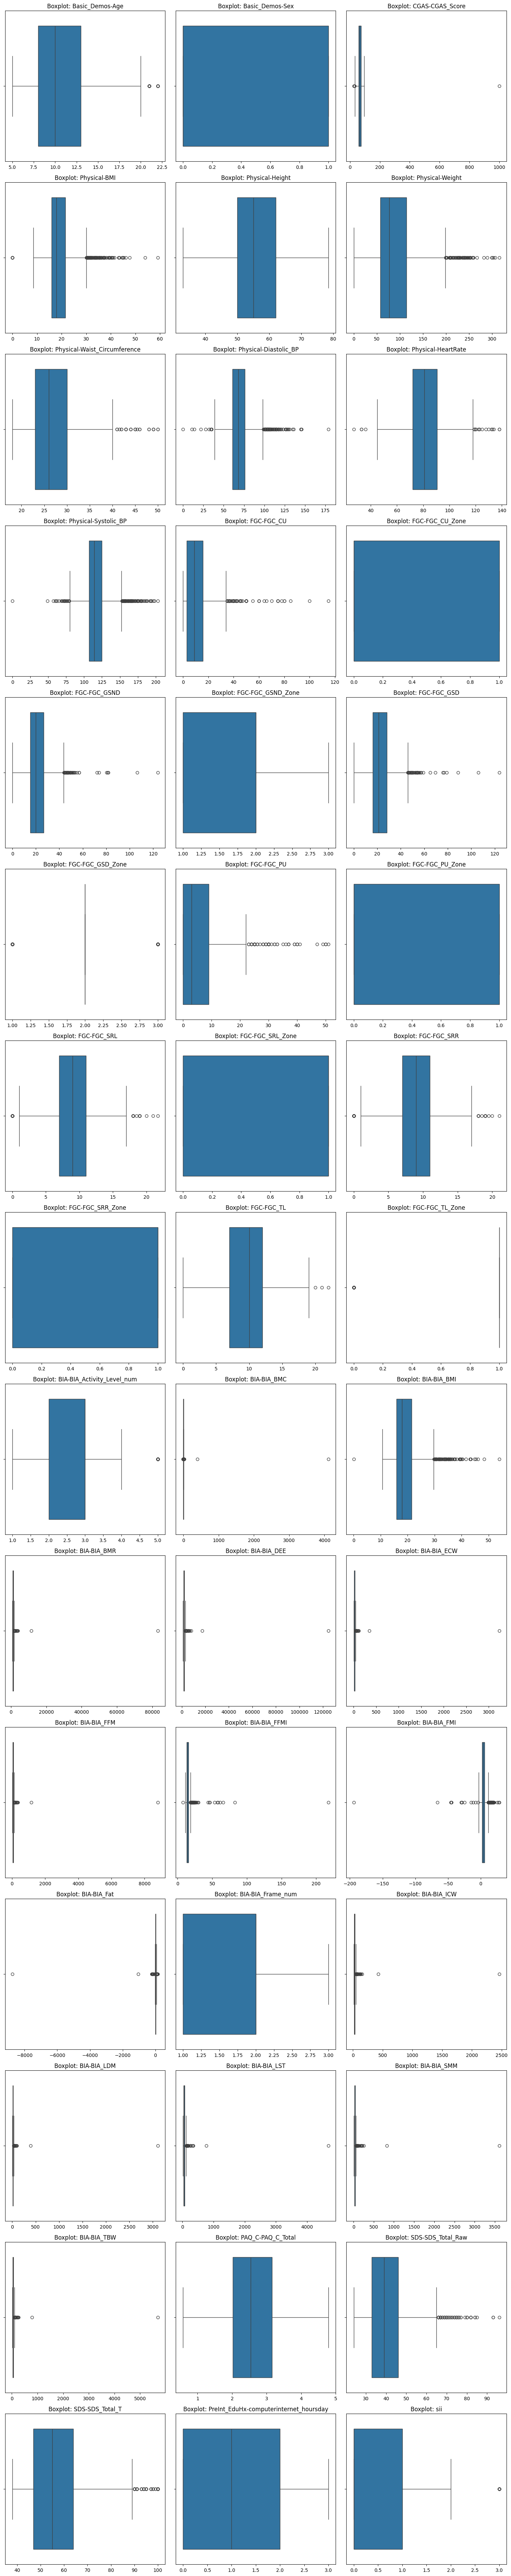

In [3]:
# Facciamo il plot dei dati numerici e vediamo se ci sono errori
plot_features_with_outliers(data)

In [4]:
def instances_cleaning(data):
    rows_to_remove = []
    
    # Non possono esserci valori troppo alti per CGAS-CGAS_Score
    rows_to_remove += data[data['CGAS-CGAS_Score'] > 800].index.tolist()
    
    # Il BMI non può essere <= 0
    rows_to_remove += data[data['Physical-BMI'] <= 0].index.tolist()

    # La pressione diastolica non può essere < 20 o > 150
    rows_to_remove += data[(data['Physical-Diastolic_BP'] < 20) | (data['Physical-Diastolic_BP'] > 150)].index.tolist()
    
    # La frequenza cardiaca non può essere inferiore a 40
    rows_to_remove += data[data['Physical-HeartRate'] < 40].index.tolist()
    
    # La pressione sistolica non può essere inferiore a 50
    rows_to_remove += data[data['Physical-Systolic_BP'] < 50].index.tolist()
    
    # Impostiamo a NaN i valori di grasso corporeo negativo, ma non rimuoviamo le righe. Ci sono troppe righe che hanno valori anomali
    data.loc[data['BIA-BIA_Fat'] < 0, 'BIA-BIA_Fat'] = np.nan
    
    # La massa muscolare scheletrica non può superare i 500
    rows_to_remove += data[data['BIA-BIA_SMM'] > 500].index.tolist()
    
    # Massa muscolare scheletrica troppo alta (> 500)
    rows_to_remove += data[data['BIA-BIA_SMM'] > 500].index.tolist()
    
    # L'acqua extracellulare non può essere troppo alta
    rows_to_remove += data[data['BIA-BIA_ECW'] > 400].index.tolist()
    
    # L'acqua intracellulare non può essere maggiore di 400
    rows_to_remove += data[data['BIA-BIA_ICW'] > 400].index.tolist()
    
    # La massa magra (Lean Soft Tissue) non può essere troppo alta
    rows_to_remove += data[data['BIA-BIA_LST'] > 4000].index.tolist()
    
    # Il totale di acqua corporea non può superare 1000
    rows_to_remove += data[data['BIA-BIA_TBW'] > 1000].index.tolist()
    
    index_counter = Counter(rows_to_remove)
    
    # Filtra gli indici che compaiono meno di 3 volte (quindi vengono rimossi)
    # Ci sono alcune occorrenze che eccedeno molte volte, teniamo dato che potrebbero essere dei casi "limite" più che errori
    #rows_to_remove_filtered = [index for index, count in index_counter.items() if count < 3]

    # Nelle analisi finali risultava ancora un dato con valori anomali, escludiamolo per sicurezza commentando le righe sopra

    print("Numero di righe rimosse: " + str(len(rows_to_remove)))
    return data.drop(rows_to_remove)

data = instances_cleaning(data)
data


Numero di righe rimosse: 27


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,3.0,2.0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,21.0352,14.97400,39.4497,15.4107,27.0552,2.340,46.0,64.0,0.0,0.0
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,30.4041,16.77900,58.9338,26.4798,45.9966,2.451,31.0,45.0,0.0,1.0
4,001f3379,13,1,50.0,22.279952,59.5,112.2,NaN,60.0,73.0,...,32.9141,20.90200,79.6982,35.3804,63.1265,4.110,40.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,fe7c87e2,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.880,NaN,NaN,NaN,NaN
3777,fe7f68a7,15,1,NaN,22.457960,62.0,122.8,30.0,64.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,49.0,68.0,2.0,NaN
3778,ff0ab367,9,0,NaN,20.200490,52.5,79.2,28.0,75.0,92.0,...,NaN,NaN,NaN,NaN,NaN,1.990,NaN,NaN,0.0,NaN
3779,ffa9794a,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,...,NaN,NaN,NaN,NaN,NaN,2.340,NaN,NaN,0.0,NaN


In [5]:
def standardize_dataframe(df):
    # Seleziona le colonne numeriche (escludendo 'sii')
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = [col for col in numeric_columns if col != 'sii']

    # Mantieni i valori originali di 'sii'
    sii_original = df['sii'].copy()

    # Standardizza le colonne numeriche
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    # Ripristina i valori di 'sii'
    df['sii'] = sii_original

    return df

data = standardize_dataframe(data)
data


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,-1.524578,-0.768131,-1.179192,-0.495613,-1.330029,-0.896025,NaN,NaN,NaN,...,-0.642982,-1.168944,-0.886599,-0.703683,-0.821287,NaN,NaN,NaN,1.766029,2.0
1,000fd460,-0.402782,-0.768131,NaN,-1.059635,-1.062591,-1.005561,-0.948498,0.400570,-0.859944,...,-0.943151,-0.409438,-0.868183,-0.934869,-1.077798,-0.324041,0.457896,0.460488,-0.972485,0.0
2,00105258,-0.122333,1.301861,0.513585,-0.540989,0.074020,-0.330088,NaN,-0.350867,0.912259,...,NaN,NaN,NaN,NaN,NaN,-0.542521,-0.301916,-0.290581,0.853191,0.0
3,00115b9f,-0.402782,-0.768131,0.513585,-0.214759,0.007161,-0.193168,NaN,-0.726585,1.133785,...,-0.115946,-0.183909,-0.193700,-0.315342,-0.215672,-0.181386,-0.966752,-0.966544,-0.972485,1.0
4,001f3379,0.719014,1.301861,-1.263830,0.576696,0.475177,0.505124,NaN,-0.726585,-0.638419,...,0.105669,0.331247,0.525104,0.182815,0.564002,1.950724,-0.111963,-0.140367,-0.972485,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,fe7c87e2,0.719014,-0.768131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.915223,NaN,NaN,NaN,NaN
3777,fe7f68a7,1.279912,1.301861,NaN,0.612027,0.809475,0.747017,0.487946,-0.426010,-1.598363,...,NaN,NaN,NaN,NaN,NaN,NaN,0.742825,0.760916,0.853191,NaN
3778,ff0ab367,-0.402782,-0.768131,NaN,0.163967,-0.460856,-0.247936,0.128835,0.400570,0.764576,...,NaN,NaN,NaN,NaN,NaN,-0.773853,NaN,NaN,-0.972485,NaN
3779,ffa9794a,-0.122333,-0.768131,NaN,-0.121011,-0.327137,-0.311832,-0.050720,-0.726585,-0.269210,...,NaN,NaN,NaN,NaN,NaN,-0.324041,NaN,NaN,-0.972485,NaN


In [6]:
data = OneHotEncoderFunction(data, ['id', 'sii'])
data

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,Physical-Waist_Circumference,Physical-Weight,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_Raw,SDS-SDS_Total_T,id,sii
0,-0.632560,-0.722473,-0.495836,-0.928108,-0.844025,-0.969400,-0.928110,-0.332508,-0.332707,-0.682296,...,NaN,-1.330029,NaN,NaN,-0.896025,1.766029,NaN,NaN,00008ff9,2.0
1,-0.632560,-0.758457,-1.060583,-0.913106,-0.832828,-1.170820,-0.913108,-0.637295,-0.768295,-0.942106,...,-0.859944,-1.062591,0.295510,-0.948498,-1.005561,-0.972485,0.457896,0.460488,000fd460,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.912259,0.074020,-0.001335,NaN,-0.330088,0.853191,-0.301916,-0.290581,00105258,0.0
3,0.339064,-0.248384,-0.214645,-0.210377,-0.117594,-0.308540,-0.210359,-0.253785,-0.059797,-0.206051,...,1.133785,0.007161,-0.001335,NaN,-0.193168,-0.972485,-0.966752,-0.966544,00115b9f,1.0
4,-0.632560,-0.051028,2.148426,0.509547,0.005336,1.008394,0.509536,0.549019,2.125190,2.229413,...,-0.638419,0.475177,-0.891868,NaN,0.505124,-0.972485,-0.111963,-0.140367,001f3379,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fe7c87e2,NaN
3777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.598363,0.809475,-0.654393,0.487946,0.747017,0.853191,0.742825,0.760916,fe7f68a7,NaN
3778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.764576,-0.460856,1.482888,0.128835,-0.247936,-0.972485,NaN,NaN,ff0ab367,NaN
3779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.269210,-0.327137,0.058034,-0.050720,-0.311832,-0.972485,NaN,NaN,ffa9794a,NaN


In [7]:
# Separazione della variabile target 'sii' dalle features
y = data['sii']
X = data.drop('sii', axis=1)

# Suddivisione il dataset in training e test set
X_train_with_encoder, X_test_with_encoder, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Salvataggio degli id per utilizzarli successivamente
ids = X_train_with_encoder['id']

# Rimozione la colonna 'id' dalle features
X_train_with_encoder = X_train_with_encoder.drop(columns=['id'])
X_test_with_encoder = X_test_with_encoder.drop(columns=['id'])


In [8]:
ids # Salviamoci tutti i dati che utilizziamo per il training, i rimanenti saranno per il test

1319    80ed2bcf
1936    c09d41cd
2656    13e15532
3746    f8a1b335
756     47c3b47c
          ...   
821     4eade67b
1127    6d70e716
2727    20c37863
3191    839f40f4
1440    8d010562
Name: id, Length: 3009, dtype: object

In [9]:
# Filling dei missing values
X_train_filled_with_encoder = fill_missing_values(X_train_with_encoder)
X_test_filled_with_encoder = fill_missing_values(X_test_with_encoder)

/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [10]:
X_train_with_encoder = X_train_filled_with_encoder
X_test_with_encoder = X_test_filled_with_encoder

In [11]:
def fill_y_column(X, y_column):
    # Sostituzione dei valori NaN con -1 in y_column
    # Per funzionare far funzionare la label propagation bisogna mettere -1
    y_column_filled = y_column.copy()
    y_column_filled = y_column_filled.fillna(-1)

    # Creazione e addestramento del modello di Label Propagation
    lp = LabelPropagation(kernel='rbf', n_neighbors=10, max_iter=300)
    lp.fit(X, y_column_filled)
    
    # Predizione dei valori mancanti
    y_pred = lp.predict(X)
    
    # Sostituzione dei valori predetti dove c'erano NaN
    y_column_imputed = y_column.copy()
    y_column_imputed[np.isnan(y_column)] = y_pred[np.isnan(y_column)]
    
    # Restituzione di y_column con i valori originali e quelli sostituiti tramite Label Propagation
    return y_column_imputed

# Sostituzione dei valori mancanti nella colonna target nei set di training e test
y_train = fill_y_column(X_train_with_encoder, y_train)
y_test = fill_y_column(X_test_with_encoder, y_test)


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:322: ConvergenceWarning: max_iter=300 was reached without convergence.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


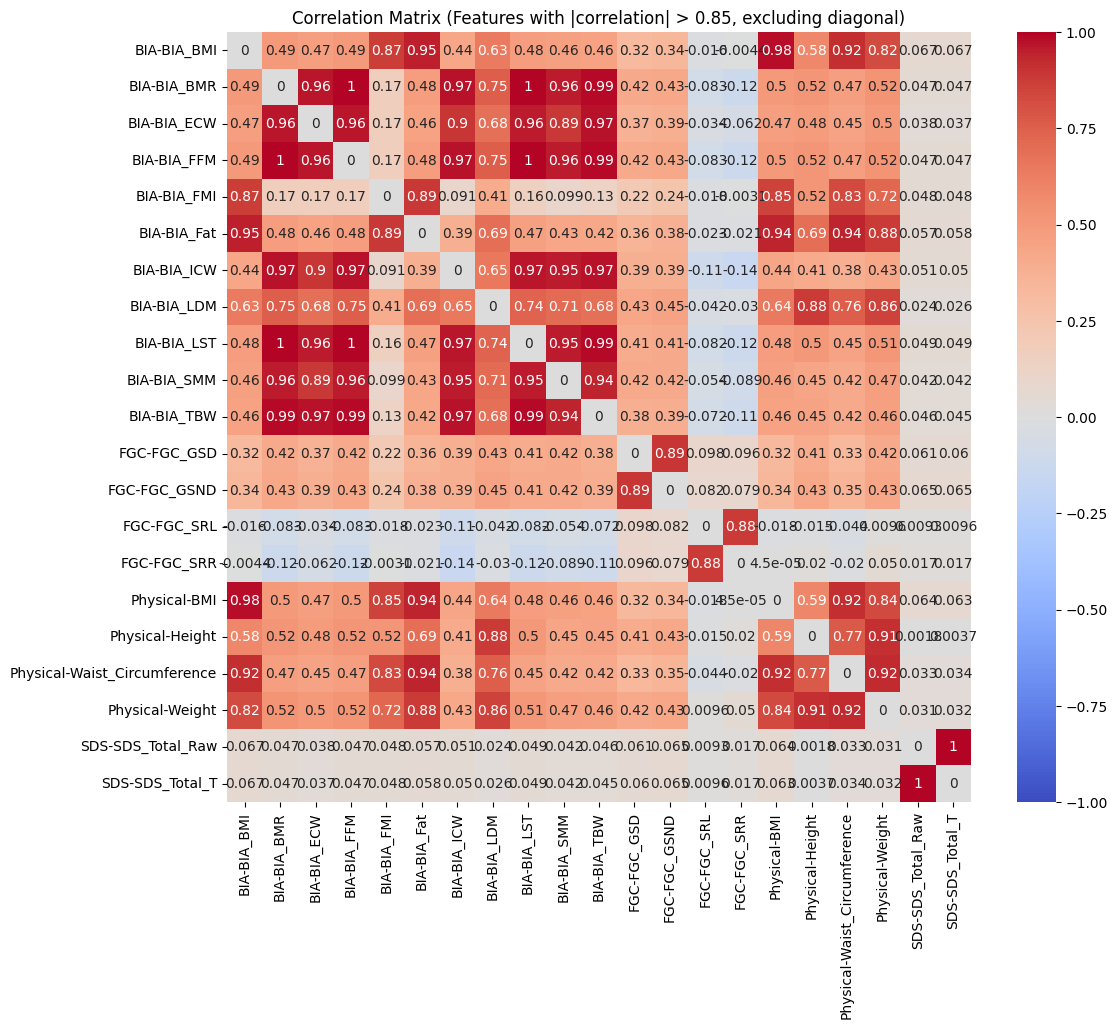

In [12]:
PrintCorrelationMatrix(X_train_with_encoder, 0.85)

## Gestione delle Correlazioni

1. **Colonne BIA-BIA**:  
   Tra le colonne 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_ICW', 'BIA-BIA_FFM', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW' e 'BIA-BIA_BMI', teniamo solo **'BIA-BIA_BMI'**, che è la misura più generica e completa.

2. **Colonne fisiche**:  
   Tra 'Physical-Waist_Circumference', 'Physical-Weight', 'BIA-BIA_BMI', 'BIA-BIA_Fat' e 'Physical-BMI', teniamo **'Physical-BMI'**, in quanto ottenuto tramite macchinario, mentre la 'BIA-BIA_BMI' è una misura calcolata.

3. **Unione delle colonne 'FGC-FGC_SRL' e 'FGC-FGC_SRR'**:  
   Le colonne 'FGC-FGC_SRL' e 'FGC-FGC_SRR' vengono unite in una nuova colonna chiamata **'FGC-FGC_SRM'**, che rappresenta la media delle due.

4. **Unione delle colonne 'FGC-FGC_GSD' e 'FGC-FGC_GSND'**:  
   Le colonne 'FGC-FGC_GSD' e 'FGC-FGC_GSND' vengono unite in una nuova colonna chiamata **'FGC-FGC_GSM'**, che rappresenta la media delle due.

5. **Rimozione delle colonne _Zone**:  
   Tutte le colonne con il suffisso **'_Zone'** vengono rimosse, in quanto sono solo categorizzazioni di altre colonne e non apportano valore aggiunto.

6. **SDS-SDS_Total_T e SDS-SDS_Total_Raw**:  
   Tra le colonne **'SDS-SDS_Total_T'** e **'SDS-SDS_Total_Raw'**, teniamo **'SDS-SDS_Total_T'**, poiché è la misura standardizzata.


In [13]:
def data_cleaning(df):
    # Per le seguenti colonne teniamo solo BIA-BIA_BMI
    to_remove = ['BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_ICW', 'BIA-BIA_FFM',
                 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']
    
    # Elimina le colonne non necessarie
    df = df.drop(columns=[col for col in to_remove if col in df.columns])

    # Tra Physical-Waist_Circumference, Physical-Weight, BIA-BIA_BMI, BIA-BIA_Fat e Physical-BMI teniamo l'ultima
    # BIA-BIA_BMI -> valore calcolato sulla base del peso e dell'altezza
    # BIA-BIA_Fat -> Percentuale di grasso corporeo calcolata tramite analisi dell'impedenza bioelettrica (BIA).
    # Physical-BMI -> misura ottenuta tramite macchinario
    to_remove = ['Physical-Waist_Circumference', 'Physical-Weight', 'BIA-BIA_Fat', 'BIA-BIA_BMI']
    df = df.drop(columns=[col for col in to_remove if col in df.columns])
    
    # Calcola la media tra 'FGC-FGC_SRL' e 'FGC-FGC_SRR'
    # FGC-FGC_SRL -> Forza di presa della mano dominante (misurata con un dinamometro)
    # FGC-FGC_SRR -> Forza di presa della mano non dominante (misurata con un dinamometro)
    if {'FGC-FGC_SRL', 'FGC-FGC_SRR'}.issubset(df.columns) and 'FGC-FGC_SRM' not in df.columns:
        df['FGC-FGC_SRM'] = (df['FGC-FGC_SRL'] + df['FGC-FGC_SRR']) / 2
        df = df.drop(columns=['FGC-FGC_SRL', 'FGC-FGC_SRR'])

    # Calcola la media tra 'FGC-FGC_GSD' e 'FGC-FGC_GSND'
    # FGC-FGC_GSD -> Forza di presa della mano dominante (misurata specificamente per la forza)
    # FGC-FGC_GSND -> Forza di presa della mano non dominante (misurata specificamente per la forza)
    if {'FGC-FGC_GSD', 'FGC-FGC_GSND'}.issubset(df.columns) and 'FGC-FGC_GSM' not in df.columns:
        df['FGC-FGC_GSM'] = (df['FGC-FGC_GSD'] + df['FGC-FGC_GSND']) / 2
        df = df.drop(columns=['FGC-FGC_GSD', 'FGC-FGC_GSND'])

    # Rimuovi tutte le colonne _Zone, sono delle categorizzazioni di altre colonne
    zone_col = [col for col in df.columns if '_Zone' in col]
    df = df.drop(columns=zone_col)
    print(f"Colonne _Zone rimosse: {zone_col}")

    # Mantieni solo 'SDS-SDS_Total_T' e rimuovi 'SDS-SDS_Total_Raw'
    # SDS-SDS_Total_T -> Punteggio T totale della scala di disturbi del sonno (punteggio standardizzato per la qualità del sonno)
    if 'SDS-SDS_Total_Raw' in df.columns:
        df = df.drop(columns=['SDS-SDS_Total_Raw'])

    return df

X_train_with_encoder = data_cleaning(X_train_with_encoder)
X_test_with_encoder = data_cleaning(X_test_with_encoder)


Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']


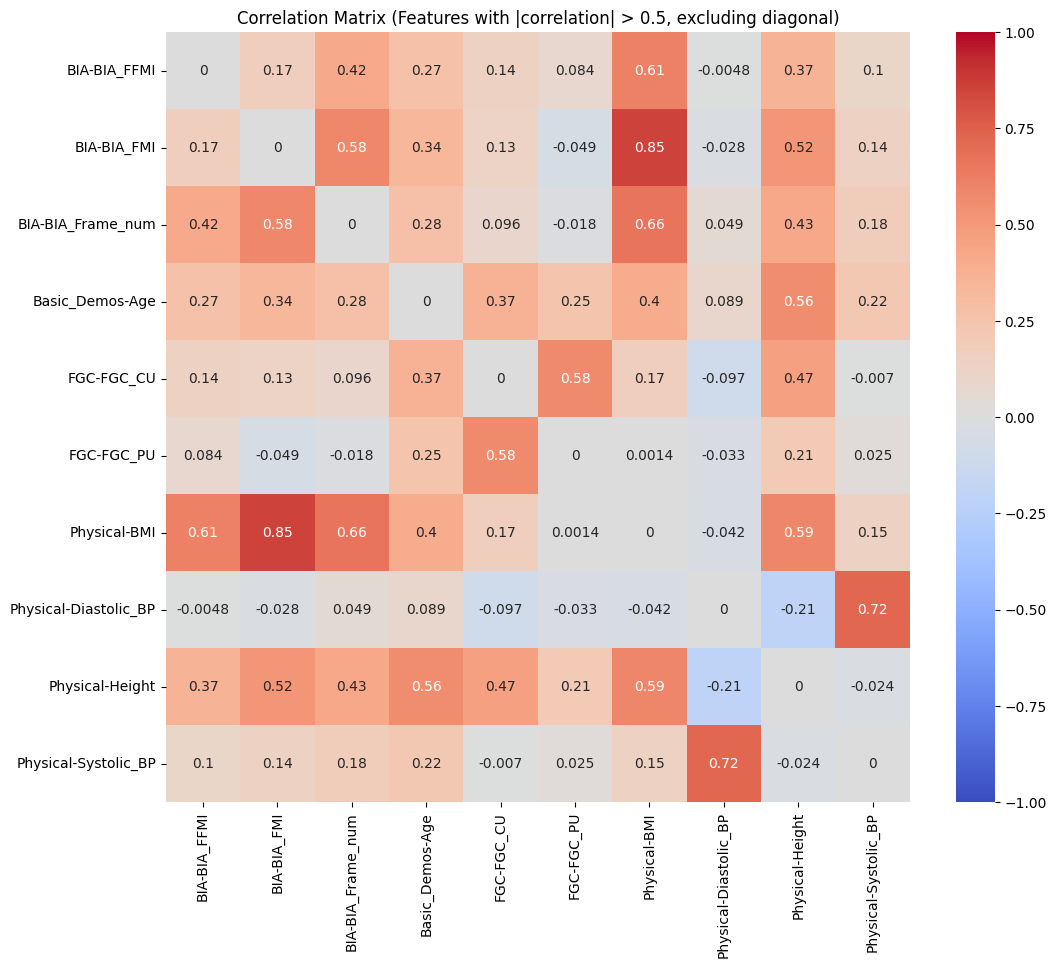

In [14]:
PrintCorrelationMatrix(X_train_with_encoder, 0.50)

## Gestione della Correlazione delle Features

La maggior parte dei problemi di correlazione tra le variabili è stata risolta. Tuttavia, permangono due colonne correlate:

1. **Physical-BMI** (misura la massa corporea)
2. **BIA-BIA_FMI** (misura la massa grassa)

Queste due variabili, pur essendo leggermente correlate, rappresentano due misurazioni distinte:

- **Physical-BMI** è una misura della massa corporea ottenuta tramite macchinario.
- **BIA-BIA_FMI** è l'indice di massa grassa calcolato tramite analisi dell'impedenza bioelettrica (BIA).

Poiché il livello di correlazione tra di esse non è elevato e le due misurazioni sono fondamentalmente diverse le teniamo separate.


In [15]:
X_train_with_encoder

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Frame_num,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,FGC-FGC_CU,FGC-FGC_PU,...,PAQ_C-PAQ_C_Total,Physical-BMI,Physical-Diastolic_BP,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_T,FGC-FGC_SRM,FGC-FGC_GSM
1319,-1.604185,2.247030,1.941278,1.422111,0.373569,1.279912,-0.768131,1.275335,1.081497,-0.213505,...,-0.127807,2.452367,1.377437,0.026158,1.411210,1.957839,0.853191,0.460488,-1.021134,0.887093
1936,0.339064,-0.515594,0.375416,3.098471,0.373569,2.682156,1.301861,-1.687025,-0.407181,-0.597684,...,-0.525043,0.937259,0.400570,0.247683,1.143772,0.236141,0.853191,-0.666116,-0.146976,-0.216088
2656,0.232185,-0.716478,-0.384818,-0.485729,-0.287848,-0.963680,-0.768131,-0.348038,-0.953143,-0.754602,...,0.165727,-0.650191,-0.350867,-0.933786,-0.728294,-0.357548,-0.972485,0.084953,-1.822691,-0.400040
3746,0.105874,-0.756018,-0.392975,-0.653933,-0.184961,-0.963680,-0.768131,0.120015,-0.509761,0.365470,...,0.046835,-0.895137,1.763676,1.929061,-1.938718,1.456766,0.259846,0.084953,-0.226593,-0.124439
756,-0.632560,-0.467832,-0.485715,-0.540762,-1.096247,-0.683231,-0.768131,-0.332803,-0.698813,-0.619328,...,1.886465,-0.769950,-0.801728,-1.376837,-0.527715,-1.069975,-0.972485,0.385381,0.948425,-0.125194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,-0.632560,-0.778364,-0.362271,-0.278433,0.373569,-1.244129,-0.768131,0.259669,-0.953143,-0.754602,...,-0.204892,-0.469106,0.175139,0.321525,-1.463748,-0.298179,-0.972485,1.812413,0.219287,-0.871067
1127,-0.632560,0.219948,1.120076,2.493238,1.843385,0.438565,1.301861,0.852141,0.488060,-0.754602,...,-0.786705,2.824473,0.776288,0.764576,0.742615,-0.238810,0.688880,0.160060,-0.656490,-0.274372
2727,0.193320,-0.708523,-0.671215,-0.717024,-0.493622,-0.963680,-0.768131,-0.614651,-0.953143,-0.754602,...,0.574555,-1.208297,-1.102303,-0.047684,-1.029161,-1.129344,-0.972485,0.084953,-0.218376,-0.390613
3191,0.154455,-0.747907,-0.401528,-0.656256,-0.376037,-0.963680,-0.768131,0.241048,-0.509761,-0.206741,...,0.391392,-0.902716,0.926575,0.390936,-1.955566,0.766899,-0.068776,0.084953,-0.230482,-0.453107


In [16]:
# Conteggio della distribuzione delle etichette nel training set
train_counts = y_train.value_counts()

# Conteggio della distribuzione delle etichette nel test set
test_counts = y_test.value_counts()

# Visualizzazione della distribuzione delle etichette nel training set
print("Distribuzione delle etichette nel training set:")
print(train_counts)

# Visualizzazione della distribuzione delle etichette nel test set
print("Distribuzione delle etichette nel test set:")
print(test_counts)


Distribuzione delle etichette nel training set:
sii
0.0    1764
1.0     832
2.0     384
3.0      29
Name: count, dtype: int64
Distribuzione delle etichette nel test set:
sii
0.0    491
1.0    185
2.0     67
3.0     10
Name: count, dtype: int64


Il dataset è fortemente sbilanciato.  
Per la valutazione dei modelli utilizziamo una metrica basata su una media ponderata, dove i pesi sono calcolati in base alla proporzione inversa della quantità di istanze per ciascuna classe.
Evitiamo quindi di andare in overfitting sulle classi 0 e 1.

In [17]:
# Funzione per calcolare l'accuratezza bilanciata inversa
def inverse_balanced_accuracy(y_true, y_pred):
    # Converte le etichette in array di interi
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    
    # Calcola la frequenza di ciascuna classe nel dataset
    class_counts = np.bincount(y_true)
    total_samples = len(y_true)
    
    # Calcola la frequenza inversa di ciascuna classe
    class_weights = total_samples / class_counts
    # Normalizza i pesi affinché la somma totale sia 1
    class_weights = class_weights / np.sum(class_weights)

    # Assegna un peso ad ogni campione in base alla sua classe
    sample_weights = class_weights[y_true]

    # Calcola l'accuratezza bilanciata utilizzando i pesi per compensare il bilanciamento delle classi
    acc = balanced_accuracy_score(y_true, y_pred, sample_weight=sample_weights)
    
    return acc

## Random Forest

In [18]:
# Selezione delle feature tramite Recursive Feature Elimination con Cross-Validation (RFECV)
column_number, selected_features = rfecv_selection(X_train_with_encoder, y_train)

# Visualizza il numero di feature selezionate
print(f"Numero di feature selezionate: {column_number}")

# Visualizza l'elenco delle feature selezionate
print(f"Feature selezionate: {selected_features}")


Numero di feature selezionate: 17
Feature selezionate: ['BIA-BIA_BMC', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'PAQ_C-PAQ_C_Total', 'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height', 'Physical-Systolic_BP', 'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'FGC-FGC_SRM', 'FGC-FGC_GSM']


In [19]:
# Selezione delle feature tramite RFE con il numero di feature selezionate definito precedentemente
column = rfe_selection(X_train_with_encoder, y_train, column_number)

# Crea un nuovo DataFrame concatenando le feature selezionate con il target (y_train)
data = pd.concat([X_train_with_encoder[column], y_train], axis=1)

# Mostra le colonne selezionate
column

# L'ordine delle colonne tra rfecv e rfe combacia

Index(['BIA-BIA_BMC', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'Basic_Demos-Age',
       'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'FGC-FGC_CU', 'PAQ_C-PAQ_C_Total',
       'Physical-BMI', 'Physical-Diastolic_BP', 'Physical-HeartRate',
       'Physical-Height', 'Physical-Systolic_BP',
       'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T',
       'FGC-FGC_SRM', 'FGC-FGC_GSM'],
      dtype='object')

In [20]:
def grid_search_rf(X_train, y_train):
    # Inizializzazione del modello con bilanciamento delle classi
    model = RandomForestClassifier(n_jobs=-1, class_weight="balanced")

    param_grid = {
        'max_depth': [10, 80, 100], 
        'min_samples_leaf': [1, 3, 5],
        'max_leaf_nodes': [None, 5, 10, 20]
    }
    # Rendiamolo un po' più veloce :)
    param_grid = {'max_depth': [80], 'max_leaf_nodes': [None], 'min_samples_leaf': [1]} # Già calcolato

    # Esecuzione della ricerca con validazione incrociata
    grid_search = GridSearchCV(model, param_grid, cv=10)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_params_

parameters = grid_search_rf(X_train_with_encoder, y_train)

Best parameters: {'max_depth': 80, 'max_leaf_nodes': None, 'min_samples_leaf': 1}


Train Accuracy: 1.0000
Test Accuracy: 0.6547
Train Balanced Accuracy: 1.0000
Test Balanced Accuracy: 0.3132


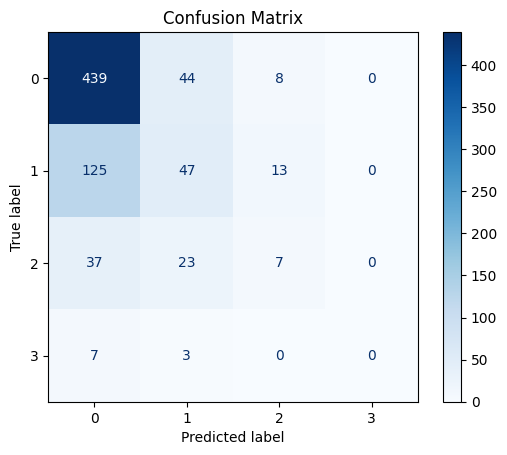

In [21]:
# Creazione del modello con i migliori parametri trovati dal grid search
model = RandomForestClassifier(**parameters)

# Allenamento del modello
model.fit(X_train_with_encoder, y_train)

# Predizione per il training e il test set
y_train_pred = model.predict(X_train_with_encoder)
y_test_pred = model.predict(X_test_with_encoder[X_train_with_encoder.columns])

# Calcolo dell'accuracy per il training e il test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calcolo della balanced accuracy per il training e il test
train_balanced_accuracy = inverse_balanced_accuracy(y_train, y_train_pred)
test_balanced_accuracy = inverse_balanced_accuracy(y_test, y_test_pred)

# Aggiunta dei risultati alla lista dei modelli
models.append({ 
    'model_name': 'Random Forest',
    'model': model,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_accuracy': train_balanced_accuracy,
    'test_balanced_accuracy': test_balanced_accuracy
})

# Stampa delle metriche e della matrice di confusione
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
print_confusion_matrix(y_test, y_test_pred)


Della classe 3 non è stato in grado di predirne nessuno, anzi tende molto a focalizzarsi sulla classe 0.

## Artifical Neural Network

In [22]:
# Conversione da una classe ad un array di probabilità per ciascuna classe
y_train_categorial = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_categorial = to_categorical(y_test, num_classes=len(np.unique(y_train)))

Definiamo una funzione `create_model(X_train, y_train, n_neurons=64, hidden_layer=1, dropout=True, activation='relu')`.

La funzione crea un modello neurale composto da:

1. Un layer di input di dimensioni pari al numero di caratteristiche di `X_train`.
2. Un numero di layer nascosti (`hidden_layer`), ciascuno con `n_neurons` neuroni e la funzione di attivazione specificata (`activation`). Se `dropout` è `True`, viene applicato un dropout del 25% al penultimo layer nascosto.
3. Un layer di output con un numero di neuroni pari al numero di classi uniche in `y_train`, con funzione di attivazione `softmax` per restituire un array di probabilità di appartenenza.

Il modello viene compilato utilizzando l'ottimizzatore Adam con un learning rate di 0.01, la funzione di perdita `categorical_crossentropy` e la metrica di valutazione `accuracy`.


In [23]:
# Creazione del modello
def create_model(X_train, y_train, n_neurons=64, hidden_layer=1, dropout=True, activation='relu'):
    # Verifica della presenza di almeno un layer nascosto
    if hidden_layer < 1:
        raise ValueError("There should be at least one hidden layer")

    # Inizializzazione del modello
    model = Sequential()
    # Aggiunta del layer di input
    model.add(Input(shape=(X_train.shape[1],)))

    # Aggiunta dei layer nascosti
    for i in range(hidden_layer - 1):
        model.add(Dense(n_neurons, activation=activation))
    
    # Aggiunta del Dropout (se abilitato)
    if dropout:
        model.add(Dropout(0.25))
        
    # Aggiunta dell'ultimo layer nascosto
    model.add(Dense(n_neurons, activation=activation))

    # Aggiunta del layer di output
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))

    # Compilazione del modello
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [24]:
# Definisci i pesi per ogni classe
weights_per_class = {
    0: [0.5, 0.8],
    1: [0.5, 0.8, 1],
    2: [1.5, 2],
    3: [1.5, 2]
}

# Crea una lista di tutte le combinazioni possibili di pesi
weight_combinations = list(itertools.product(*weights_per_class.values()))

# Funzione per ottenere i pesi dei campioni basata sulle combinazioni di pesi
def get_sample_weights(y, weight_combination, weights_per_class):
    sample_weights = np.zeros_like(y, dtype=float)
    for class_label, weight in zip(weights_per_class.keys(), weight_combination):
        # Trova gli indici dei campioni appartenenti a ciascuna classe
        class_indices = np.where(y == class_label)[0]
        # Assegna il peso appropriato a ciascun campione
        sample_weights[class_indices] = weight
    return sample_weights

# Parametri da testare
n_neurons_options = [32, 64]
hidden_layer_options = [1, 3, 5, 10]
dropout_options = [True, False]

# Variabili per tracciare i migliori risultati
best_score = -np.inf
best_params = {}

# Velocizziamo un po' il lavoro
n_neurons_options = [64]
hidden_layer_options = [5]
dropout_options = [True]
weight_combinations = [(0.5, 0.8, 1.5, 1.5)]

# Combinazione di tutte le possibili configurazioni di parametri
param_combinations = itertools.product(n_neurons_options, hidden_layer_options, dropout_options)

# Loop su tutte le combinazioni di parametri e pesi
for n_neurons, hidden_layer, dropout in param_combinations:
    for weight_combination in weight_combinations:
        print(f"Training con {n_neurons} neuroni, {hidden_layer} hidden layers, dropout={dropout}")
        print(f"Utilizzando la combinazione di pesi: {weight_combination}")

        # Ottieni i pesi per i campioni basati sulla combinazione corrente di pesi
        sample_weights = get_sample_weights(y_train, weight_combination, weights_per_class)

        # Crea il modello con i parametri correnti
        model = create_model(X_train_with_encoder, y_train, n_neurons=n_neurons, hidden_layer=hidden_layer, dropout=dropout)
        
        # Allena il modello
        model.fit(
            X_train_with_encoder, 
            y_train_categorial, 
            epochs=10, 
            batch_size=128, 
            verbose=0, 
            sample_weight=sample_weights  # Applica i pesi ai campioni
        )

        # Calcola le previsioni e la balanced accuracy per il training
        y_pred_train = model.predict(X_train_with_encoder)
        y_pred_train_numerical = np.argmax(y_pred_train, axis=1)  # Converte le previsioni one-hot in numeriche
        score_train = inverse_balanced_accuracy(np.argmax(y_train_categorial, axis=1), y_pred_train_numerical)
        
        # Calcola le previsioni e la balanced accuracy per il test
        y_pred_test = model.predict(X_test_with_encoder)
        y_pred_test_numerical = np.argmax(y_pred_test, axis=1)  # Converte le previsioni one-hot in numeriche
        score_test = inverse_balanced_accuracy(np.argmax(y_test_categorial, axis=1), y_pred_test_numerical)

        print(f"Balanced Accuracy Train: {score_train}")
        print(f"Balanced Accuracy Test: {score_test}")

        # Aggiorna i migliori parametri se si trova un punteggio migliore
        if score_test > best_score:
            best_score = score_test
            best_params = {
                'n_neurons': n_neurons,
                'hidden_layer': hidden_layer,
                'dropout': dropout,
                'weights': weight_combination
            }

# Stampa i migliori parametri e il punteggio migliore
print(f"Migliori parametri: {best_params}")
print(f"Punteggio migliore di balanced accuracy: {best_score}")


Training con 64 neuroni, 5 hidden layers, dropout=True
Utilizzando la combinazione di pesi: (0.5, 0.8, 1.5, 1.5)


W0000 00:00:1738244400.600358   88119 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
Balanced Accuracy Train: 0.5935724228904641
Balanced Accuracy Test: 0.29904061735687726
Migliori parametri: {'n_neurons': 64, 'hidden_layer': 5, 'dropout': True, 'weights': (0.5, 0.8, 1.5, 1.5)}
Punteggio migliore di balanced accuracy: 0.29904061735687726


In [25]:
# Funzione per plottare la perdita e l'accuratezza durante l'allenamento
def plot_ann(history):
    # Plot della perdita (training e validazione)
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot dell'accuratezza (training e validazione)
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Accuracy During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Crea il modello con i migliori parametri
model = create_model(
    X_train_with_encoder, y_train, 
    n_neurons=best_params['n_neurons'], 
    hidden_layer=best_params['hidden_layer'], 
    dropout=best_params['dropout']
)

# Callback per interrompere l'allenamento e ridurre il learning rate
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(verbose=1)

# Allenamento del modello
history = model.fit(
    X_train_with_encoder, y_train_categorial, 
    epochs=45, validation_data=(X_test_with_encoder, y_test_categorial),
    class_weight={i: best_params['weights'][i] for i in range(len(best_params['weights']))}, 
    callbacks=[lr_scheduler, early_stopping]
)

# Salvataggio del modello allenato
annModel = model

Epoch 1/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5078 - loss: 0.8258 - val_accuracy: 0.4608 - val_loss: 1.0858 - learning_rate: 0.0100
Epoch 2/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.5885 - loss: 0.7093 - val_accuracy: 0.4954 - val_loss: 1.0183 - learning_rate: 0.0100
Epoch 3/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.6122 - loss: 0.6803 - val_accuracy: 0.5803 - val_loss: 0.9081 - learning_rate: 0.0100
Epoch 4/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.6040 - loss: 0.6688 - val_accuracy: 0.5166 - val_loss: 1.0701 - learning_rate: 0.0100
Epoch 5/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.6297 - loss: 0.6421 - val_accuracy: 0.3931 - val_loss: 1.1782 - learning_rate: 0.0100
Epoch 6/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.5808 - loss: 0.6578 - val_accuracy: 0.5286 - val_loss: 1.0046 - learning_rate: 0.0100
Epoch 7/45
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.6066 - loss: 0.6401 - va

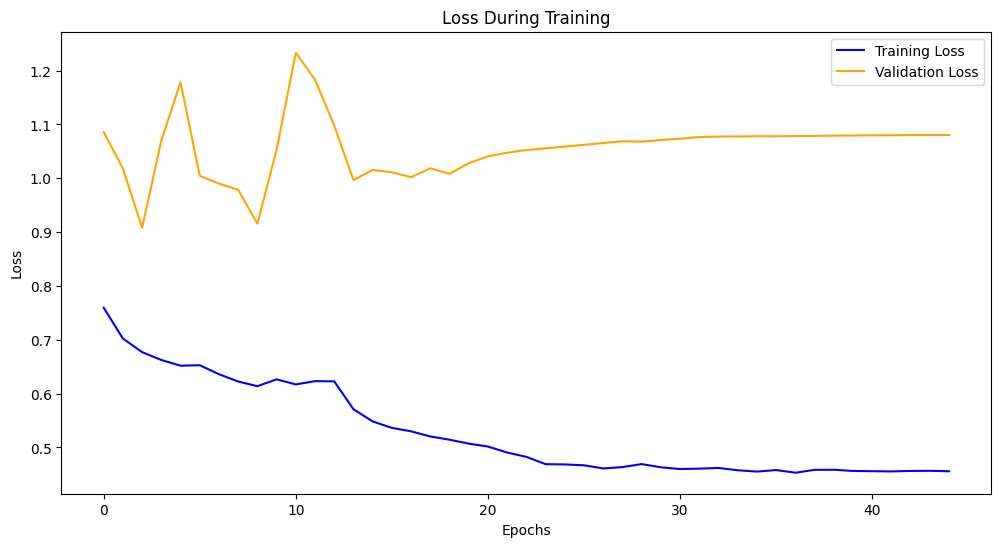

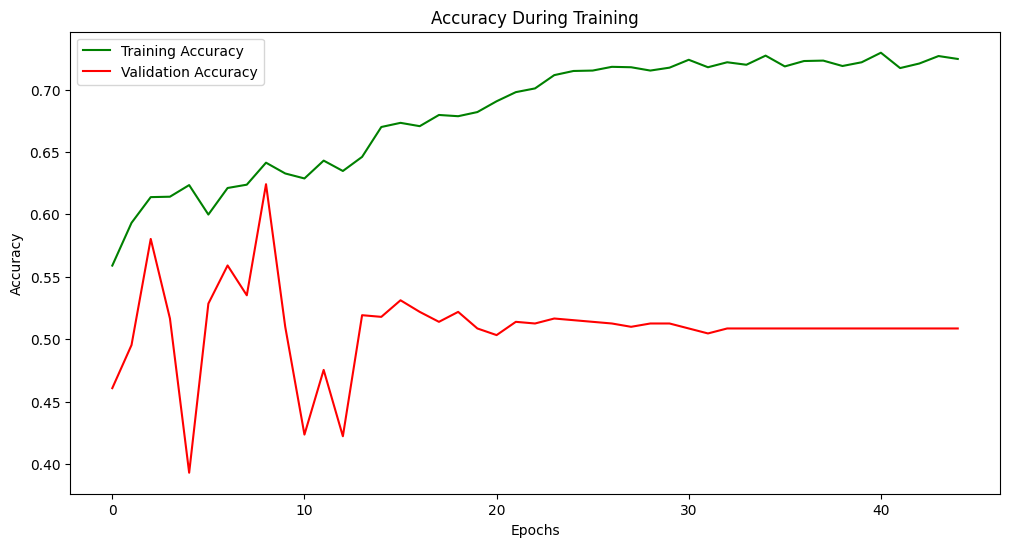

In [26]:
plot_ann(history)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
Train Accuracy: 0.6068
Test Accuracy: 0.5803
Train Balanced Accuracy: 0.4167
Test Balanced Accuracy: 0.3868


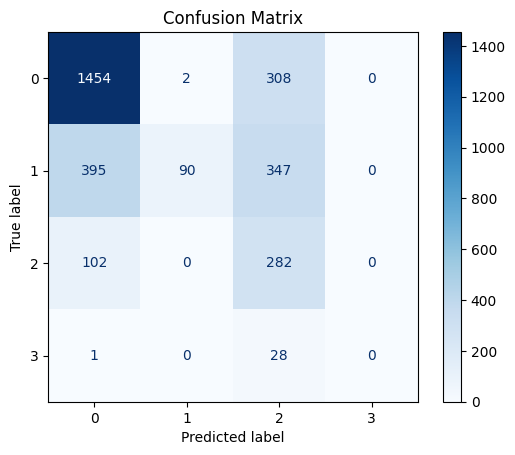

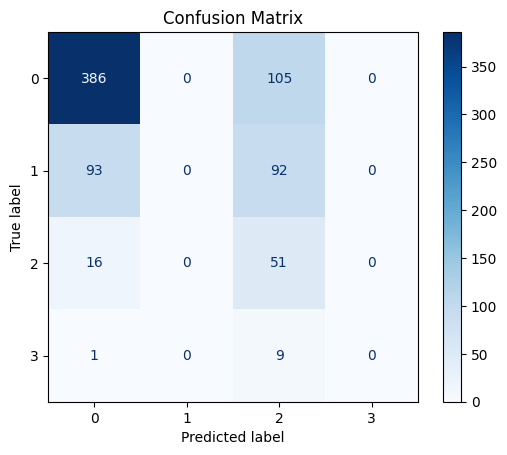

In [27]:
y_train_pred = model.predict(X_train_with_encoder)
y_test_pred = model.predict(X_test_with_encoder[X_train_with_encoder.columns])

# Converti le probabilità in etichette discrete (classi)
y_train_pred_label = np.argmax(y_train_pred, axis=1)
y_test_pred_label = np.argmax(y_test_pred, axis=1)

# Calcola l'accuracy per il training e il test
train_accuracy = accuracy_score(y_train, y_train_pred_label)
test_accuracy = accuracy_score(y_test, y_test_pred_label)

# Calcola la balanced accuracy per il training e il test
train_balanced_accuracy = inverse_balanced_accuracy(y_train, y_train_pred_label)
test_balanced_accuracy = inverse_balanced_accuracy(y_test, y_test_pred_label)

models.append({ 
    'model_name': 'ANN',
    'model': model,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_accuracy': train_balanced_accuracy,
    'test_balanced_accuracy': test_balanced_accuracy
})

# Stampa i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

# Stampa la matrice di confusione
print_confusion_matrix(y_train, y_train_pred_label)
print_confusion_matrix(y_test, y_test_pred_label)


Rispetto alla random forest il modello è generalmente migliore. 
Ha una tendenza a classificare 0 e 2.
Anche in questo caso non è riuscito a predirre il 3.

# LightGBM

Poiché in precedenza è stato utilizzato il OneHotEncoder, ma LightGBM supporta direttamente le feature categoriali, ripetiamo il processo di preparazione dei dati, assicurandoci di utilizzare per il training le stesse istanze già selezionate in precedenza.


In [28]:
if len(ids) == 0:
    print("L'array di ids è vuoto!")

data = pd.read_csv('train.csv')
data = pre_processing(data)
data = instances_cleaning(data)
data = standardize_dataframe(data)

# Sepazione dell dataset in base agli 'id' per creare lo stesso set di allenamento e test
train = data[data['id'].isin(ids)]
test = data[~data['id'].isin(ids)]

train_without_encoder = train.drop(columns=['id'])
test_without_encoder = test.drop(columns=['id'])

X_train_without_encoder = train_without_encoder.drop(columns=['sii'])
y_train_without_encoder = train_without_encoder['sii']

X_test_without_encoder = test_without_encoder.drop(columns=['sii'])
y_test_without_encoder = test_without_encoder['sii']

X_train_filled_without_encoder = fill_missing_values(X_train_without_encoder)
X_test_filled_without_encoder = fill_missing_values(X_test_without_encoder)

X_train_without_encoder = data_cleaning(X_train_without_encoder)
X_test_without_encoder = data_cleaning(X_test_without_encoder)

y_train_without_encoder = fill_y_column(X_train_filled_without_encoder, y_train_without_encoder)
y_test_without_encoder = fill_y_column(X_test_filled_without_encoder, y_test_without_encoder)


Colonne season rimosse: 10
Colonne rimosse: 4
Righe rimosse con l'80% dei dati mancanti: 179
Numero di righe con 'sii' null: 1224
Numero di righe rimosse: 27


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']
Colonne _Zone rimosse: ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:322: ConvergenceWarning: max_iter=300 was reached without convergence.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:322: ConvergenceWarning: max_iter=300 was reached without convergence.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [30]:
# Crea lo scorer personalizzato
inverse_balanced_accuracy_scorer = make_scorer(inverse_balanced_accuracy, greater_is_better=False)

# Parametri da ottimizzare con Grid Search
param_grid = {
    'objective': ['multiclass'],              # Tipo di classificazione
    'num_class': [len(np.unique(y_train))],   # Numero di classi
    'boosting_type': ['gbdt'],                # Tipo di boosting
    'metric': ['multi_error'],                # Metrica di valutazione
    'learning_rate': [0.1],       # Tasso di apprendimento
    'num_leaves': [15],               # Numero di foglie
    'max_depth': [5],             # Profondità massima
}

# Creazione del dataset per LightGBM
train_data = lgb.Dataset(X_train_without_encoder, label=y_train)
test_data = lgb.Dataset(X_test_without_encoder, label=y_test, reference=train_data)

# Crea il modello LightGBM
model = lgb.LGBMClassifier()

# Configura la Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=inverse_balanced_accuracy_scorer,  # Usa la metrica personalizzata
    cv=3,                                      # Cross-validation a 3 fold
    verbose=1,                                 # Mostra i dettagli dell'esecuzione
    n_jobs=-1                                   # Usa tutti i core disponibili
)

# Esegui la Grid Search
grid_search.fit(X_train_without_encoder, y_train)

# Stampa i migliori parametri
print("Migliori Parametri Trovati:", grid_search.best_params_)

# Recupera il miglior modello
best_model = grid_search.best_estimator_

# Fare previsioni sul training e test set
y_train_pred = best_model.predict(X_train_without_encoder)
y_test_pred = best_model.predict(X_test_without_encoder)

# Convertire le probabilità in etichette
y_train_pred_label = y_train_pred
y_test_pred_label = y_test_pred

# Calcolare le metriche
train_accuracy = accuracy_score(y_train, y_train_pred_label)
test_accuracy = accuracy_score(y_test, y_test_pred_label)

train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred_label)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred_label)

# Stampa dei risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2237
[LightGBM] [Info] Number of data points in the train set: 2006, number of used features: 21
[LightGBM] [Info] Start training from score -0.534024
[LightGBM] [Info] Start training from score -1.286733
[LightGBM] [Info] Start training from score -2.058721
[LightGBM] [Info] Start training from score -4.608166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [31]:
# Creazione del dataset per LightGBM
train_data = lgb.Dataset(X_train_without_encoder, label=y_train)
test_data = lgb.Dataset(X_test_without_encoder, label=y_test, reference=train_data)

# Parametri del modello
params = {
    'objective': 'multiclass',          # Task di classificazione
    'num_class': len(y_train.unique()), # Numero di classi
    'boosting_type': 'gbdt',            # Tipo di boosting
    #'metric': 'multi_logloss',         # Metriche di valutazione
    'metric': 'multi_error',
    'learning_rate': 0.1,               # Tasso di apprendimento
    'num_leaves': 30,                   # Numero di foglie
    'max_depth': 15,                     # Profondità massima (non limitata)
    'verbose': 1,                      # Silenzia i log dettagliati
}

# Allenamento del modello
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=65,  #Valore trovato facendo un po' di prove
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2471
[LightGBM] [Info] Number of data points in the train set: 3009, number of used features: 21
[LightGBM] [Info] Start training from score -0.534024
[LightGBM] [Info] Start training from score -1.285531
[LightGBM] [Info] Start training from score -2.058721
[LightGBM] [Info] Start training from score -4.642067


Train Accuracy: 0.8840
Test Accuracy: 0.6228
Train Balanced Accuracy: 0.8219
Test Balanced Accuracy: 0.2555


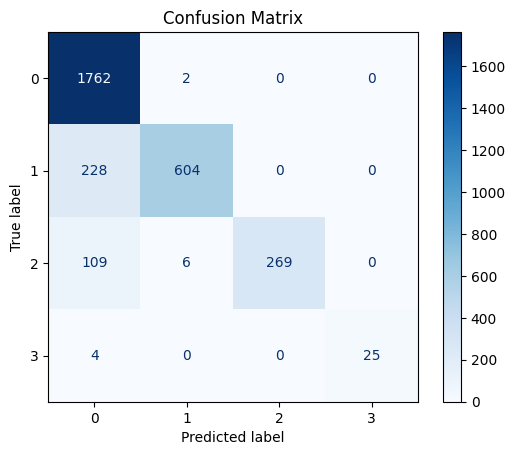

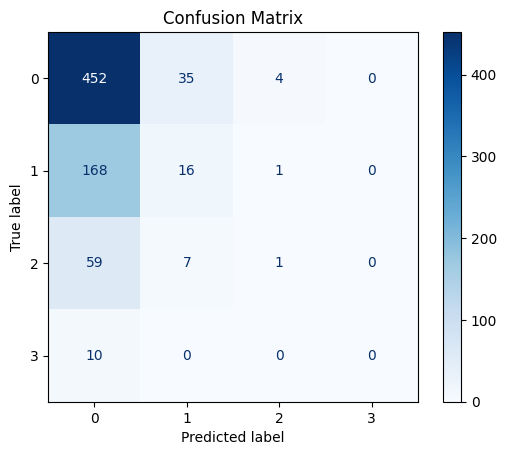

In [32]:
# Fare previsioni sul training e test set
y_train_pred = model.predict(X_train_without_encoder)
y_test_pred = model.predict(X_test_without_encoder)

# Convertire le probabilità in etichette
y_train_pred_label = y_train_pred.argmax(axis=1)
y_test_pred_label = y_test_pred.argmax(axis=1)

# Calcolare le metriche
train_accuracy = accuracy_score(y_train, y_train_pred_label)
test_accuracy = accuracy_score(y_test, y_test_pred_label)

train_balanced_accuracy = inverse_balanced_accuracy(y_train, y_train_pred_label)
test_balanced_accuracy = inverse_balanced_accuracy(y_test, y_test_pred_label)

models.append({ 
    'model_name': 'lightgbm',
    'model': model,
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_accuracy': train_balanced_accuracy,
    'test_balanced_accuracy': test_balanced_accuracy
})

# Stampare i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

# Stampa la matrice di confusione
print_confusion_matrix(y_train, y_train_pred_label)
print_confusion_matrix(y_test, y_test_pred_label)


# Analisi dei risultati
Proviamo a predire tutto il dataset con tutti i modelli e vediamo su quali istanze commette errori e poi facciamo il plot.

In [33]:
X_with_encoder = pd.concat([X_train_with_encoder, X_test_with_encoder], axis=0)
X_without_encoder = pd.concat([X_train_without_encoder, X_test_without_encoder], axis=0)

y = pd.concat([y_train, y_test], axis=0)
column_used = X_with_encoder.columns

In [42]:
lgbmModel = next(model for model in models if model['model_name'] == 'lightgbm')['model']
randomForestModel = next(model for model in models if model['model_name'] == 'Random Forest')['model']
annModel = next(model for model in models if model['model_name'] == 'ANN')['model']

# Previsioni sui dati
#y_pred_lgbm = [int(pred.argmax()) for pred in lgbmModel.predict(X_without_encoder)]
#y_pred_rf = randomForestModel.predict(X_with_encoder[randomForestModel.feature_names_in_])
y_pred_ann = annModel.predict(X_with_encoder).argmax(axis=1)

# Trova le istanze corrette e quelle errate
#mistakes = (y != y_pred_lgbm) & (y != y_pred_rf) & (y != y_pred_ann)  # Errate in tutti e tre i modelli
#correct = (y == y_pred_lgbm) & (y == y_pred_rf) & (y == y_pred_ann)  # Corrette in tutti e tre i modelli

mistakes = (y != y_pred_ann)
correct = (y == y_pred_ann)
# Verifica se ci sono sovrapposizioni
overlap = (mistakes & correct).sum()
if overlap > 0:
    print(f"ATTENZIONE: Ci sono {overlap} istanze che risultano sia corrette che errate! Controlla la logica.")
else:
    print("Nessuna sovrapposizione tra istanze corrette ed errate. La logica è corretta.")

# Output delle istanze errate
print(f"Numero di istanze errate su tutti e tre i modelli: {mistakes.sum()}")

# Output delle istanze corrette
print(f"Numero di istanze correttamente classificate da tutti e tre i modelli: {correct.sum()}")

# Estrai le istanze corrette ed errate
correct_indices = correct[correct].index
incorrect_indices = mistakes[mistakes].index

correct_features = X.loc[correct_indices]
incorrect_features = X.loc[incorrect_indices]

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
Nessuna sovrapposizione tra istanze corrette ed errate. La logica è corretta.
Numero di istanze errate su tutti e tre i modelli: 1499
Numero di istanze correttamente classificate da tutti e tre i modelli: 2263


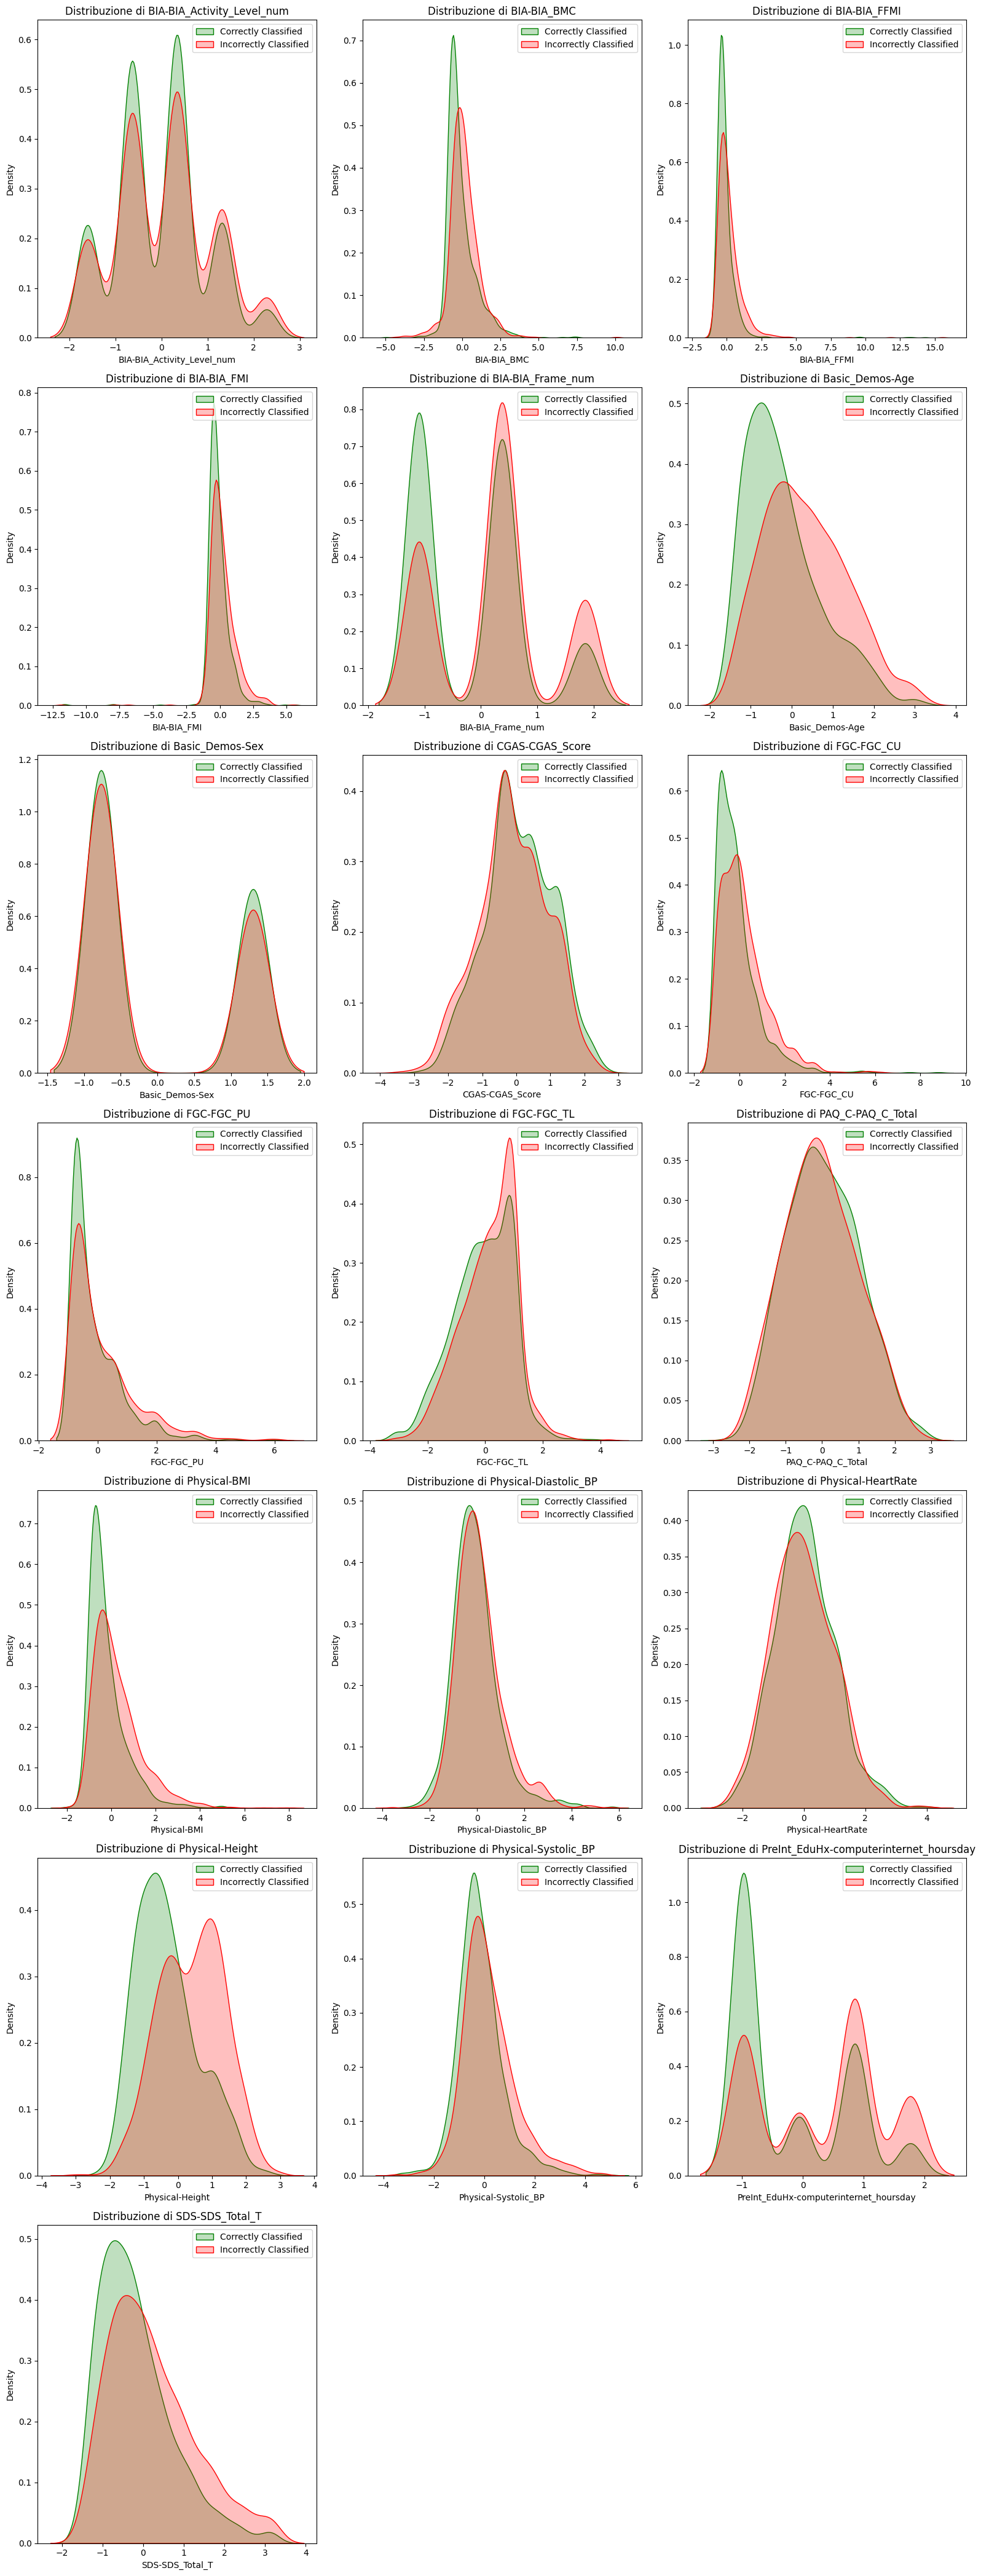

In [45]:
# Step 1: Filtra solo le feature numeriche
numeric_features = [col for col in X.select_dtypes(include=['number']).columns if col in column_used]

# Step 2: Configura il numero di righe e colonne per il grafico
num_features = len(numeric_features)
n_cols = 3
num_rows = (num_features // n_cols) + (1 if num_features % n_cols else 0)

plt.figure(figsize=(16, 6 * num_rows))  # Dimensione del grafico
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(num_rows, n_cols, i)  # Organizza i subplot
    correct_data = correct_features[feature]
    incorrect_data = incorrect_features[feature]
        
    # Traccia la distribuzione
    sns.kdeplot(correct_data, label='Correctly Classified', color='green', fill=True)
    sns.kdeplot(incorrect_data, label='Incorrectly Classified', color='red', fill=True)
    plt.title(f'Distribuzione di {feature}')
    plt.legend()

plt.tight_layout()
plt.show()


<Figure size 1500x800 with 0 Axes>

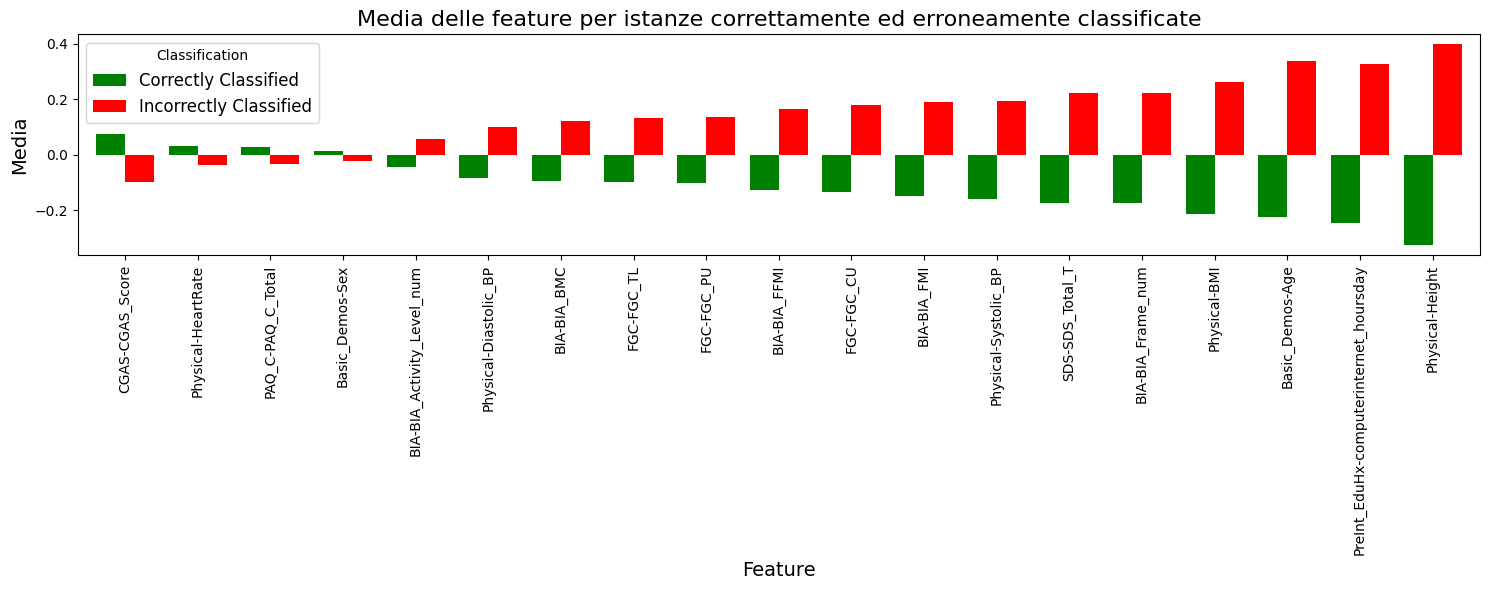

In [46]:
# Step 2: Calcolare e visualizzare la media delle feature
# Filtrare solo le colonne numeriche
numeric_features = [col for col in correct_features.select_dtypes(include=['number']).columns if col in column_used]
correct_numeric = correct_features[numeric_features]
incorrect_numeric = incorrect_features[numeric_features]

# Calcolo delle medie per le istanze corrette ed errate, ignorando i NaN
correct_means = correct_numeric.mean()
incorrect_means = incorrect_numeric.mean()

# Creare un DataFrame combinato con la media delle feature
df_means = pd.DataFrame({
    'Correctly Classified': correct_means,
    'Incorrectly Classified': incorrect_means
})

# Ordinare i dati per rendere il grafico più leggibile
df_means = df_means.sort_values(by='Correctly Classified', ascending=False)

# Plot delle medie delle feature
plt.figure(figsize=(15, 8))
df_means.plot(kind='bar', width=0.8, figsize=(15, 6), color=['green', 'red'])

# Aggiungere etichette e titolo
plt.title('Media delle feature per istanze correttamente ed erroneamente classificate', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Media', fontsize=14)
plt.xticks(rotation=90)

# Aggiungere una legenda
plt.legend(title='Classification', fontsize=12)
plt.tight_layout()

# Mostrare il grafico
plt.show()


Proviamo a creare un modello che raggruppa tutti i modelli precedenti

In [37]:
class ModelEnsemble:
    def __init__(self, models):
        self.models = models
        
    def predict(self, X):
        # Previsione per ogni modello
        predictions = []
        for model_info in self.models:
            model = model_info['model']
            if isinstance(model, lgb.LGBMClassifier):
                # Se il modello è LightGBM, usa argmax per ottenere la classe
                pred = model.predict(X, raw_score=False)  # raw_score=False per ottenere probabilità
                pred = np.argmax(pred, axis=1)  # Per problemi multiclasse
            else:
                # Altrimenti, usa il pred normale
                pred = model.predict(X)
                if isinstance(pred, np.ndarray) and pred.ndim > 1:  # Caso di classificazione multiclasse
                    pred = np.argmax(pred, axis=1)  # Applicare argmax per ottenere la classe più probabile
                predictions.append(pred)
        
        # Trasporre le previsioni per avere una lista di previsioni per ogni campione
        predictions = np.array(predictions).T  # Transpose to shape (samples, models)
        
        final_predictions = []
        for i in range(len(predictions)):
            # Moda delle previsioni per il campione i
            pred_mode = mode(predictions[i])
            
            # Se la moda è univoca, restituisci il valore
            if pred_mode.count == 1:
                # Se non c'è una moda, scegli il modello con la miglior accuracy
                best_model = max(self.models, key=lambda x: x['test_accuracy'])
                final_predictions.append(best_model['model'].predict(X.iloc[i:i+1])[0])
            else:
                # Se esiste una moda, la restituirà
                final_predictions.append(pred_mode.mode)  # Accedere al valore della moda
        
        return np.array(final_predictions)


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
Train Accuracy: 0.8840
Test Accuracy: 0.6228
Train Balanced Accuracy: 0.8219
Test Balanced Accuracy: 0.2555


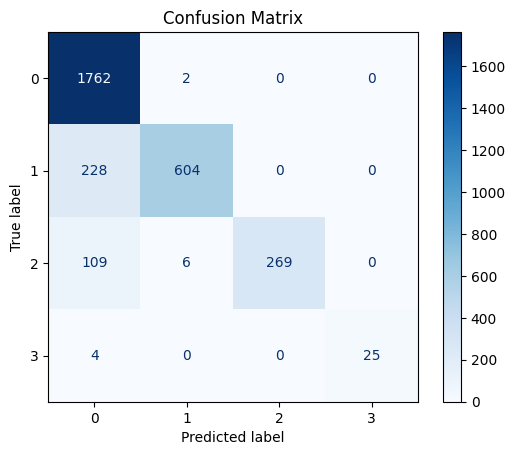

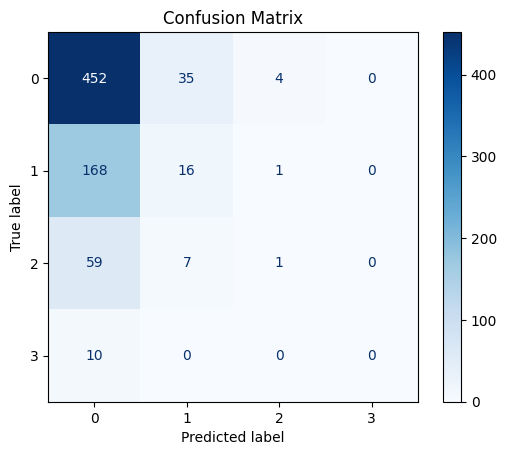

In [38]:
# Inizializza l'insieme di modelli
ensemble = ModelEnsemble(models)

# Esegui le previsioni con il modello ensemble
# usiamo solo X_with_encoder
y_pred_train = ensemble.predict(X_train_with_encoder)
y_pred_test = ensemble.predict(X_test_with_encoder)

# Visualizza le previsioni
# Calcolare le metriche
train_accuracy = accuracy_score(y_train, y_train_pred_label)
test_accuracy = accuracy_score(y_test, y_test_pred_label)

train_balanced_accuracy = inverse_balanced_accuracy(y_train, y_train_pred_label)
test_balanced_accuracy = inverse_balanced_accuracy(y_test, y_test_pred_label)

# Stampare i risultati
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Balanced Accuracy: {train_balanced_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")

# Stampa la matrice di confusione
print_confusion_matrix(y_train, y_train_pred_label)
print_confusion_matrix(y_test, y_test_pred_label)